In [130]:
import pandas as pd
import ast

ratings_df = pd.read_csv("Dataset/ratings_splits/temporal_global/filtered/train.csv") 
ratings_df_cleaned = ratings_df.drop(columns=['RatingID', 'Date', 'Vintage']).rename(columns={'WineID': 'item', 'UserID': 'user', 'Rating': 'rating'})

wines_df = pd.read_csv('Dataset/last/Xwines_Slim_1K_wines.csv')
wines_df['WineID'] = wines_df.index

group_data = pd.read_csv("Dataset/last/group_composition.csv") 
group_data['group_members'] = group_data['group_members'].apply(ast.literal_eval)

In [131]:
import pandas as pd
import ast
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from group_recommender_algs import group_rec, get_wine_with_top_categories
import importlib
import group_recommender_algs  # Dein Modul, in dem die Funktion gespeichert ist

# Neu laden des Moduls, um die Änderungen zu übernehmen
importlib.reload(group_recommender_algs)


# Load the datasets (replace 'ratings.csv' and 'wine_characteristics.csv' with the actual CSV file paths)
ratings_data = pd.read_csv('Dataset/last/XWines_Slim_150K_ratings.csv')
wine_data = pd.read_csv('Dataset/last/XWines_Slim_1K_wines.csv')
group_data = pd.read_csv('Dataset/last/group_composition.csv')  # Add path to your group CSV

# Merge the two datasets on 'WineID'
merged_data = pd.merge(ratings_data, wine_data, on='WineID')

C:\Users\antoi\AppData\Local\Temp\ipykernel_24252\1387989594.py:14: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [132]:
import seaborn as sns

count_ratings_df = ratings_df[['UserID','WineID']].groupby(['WineID']).count()
count_ratings_df_ord = count_ratings_df.sort_values(by="UserID", ascending=False).reset_index().reset_index()

users_ratings = ratings_df_cleaned.groupby(['user']).count()

selected = users_ratings['rating'] > 20
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() 
select_column_df = random_selected.reset_index()['user'] 
selected_user = select_column_df.iloc[0]

ratings_df_test = pd.read_csv("Dataset/ratings_splits/temporal_global/filtered/test.csv") 

# Remove the 'Date' and 'RatingID' columns and rename 'WineID' to 'Item' and 'UserID' to 'User'
ratings_df_cleaned_test = ratings_df_test.drop(columns=['RatingID', 'Date', 'Vintage']).rename(columns={'WineID': 'item', 'UserID': 'user', 'Rating': 'rating'})

In [133]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser


num_recs = 5  
user_user = UserUser(3, min_nbrs=2)  
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df_cleaned)

In [134]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.item_knn import ItemItem


num_recs = 5  
itemitem = ItemItem(3, min_nbrs=2)  
recsys_item = Recommender.adapt(itemitem)
recsys_item.fit(ratings_df_cleaned)

In [135]:
import pandas as pd
import ast
def recommend_group_wines_by_group_id(ratings_df, group_data, group_id, fill_method='average'):
    """
    Empfiehlt Weine basierend auf den Bewertungen einer Gruppe von Benutzern, die anhand der `group_id` identifiziert wird.

    Parameter:
    - ratings_df: DataFrame mit den Bewertungen, der die Spalten `item`, `user`, `rating` enthält.
    - group_data: DataFrame, der die Gruppeninformationen enthält, mit den Spalten `group_id` und `group_members`.
    - group_id: Die ID der Gruppe, für die Empfehlungen berechnet werden sollen.
    - fill_method: Methode zur Auffüllung der leeren Bewertungen ('average' für Durchschnitt oder 'zero' für 0).

    Rückgabe:
    - recommended_wines: DataFrame mit empfohlenen Weinen und ihren aggregierten Gruppenbewertungen oder `None`.
    """
    # Sicherstellen, dass die erforderlichen Spalten in group_data vorhanden sind
    if 'group_id' not in group_data.columns or 'group_members' not in group_data.columns:
        raise KeyError("Die Spalten 'group_id' und/oder 'group_members' fehlen in group_data. Verfügbare Spalten: "
                       f"{group_data.columns.tolist()}")

    # Konvertieren der `group_members`-Spalte in echte Listen, falls notwendig
    if isinstance(group_data['group_members'].iloc[0], str):
        group_data['group_members'] = group_data['group_members'].apply(ast.literal_eval)

    # Extrahieren der Benutzerliste für die gegebene group_id
    group_members = group_data.loc[group_data['group_id'] == group_id, 'group_members'].values
    if len(group_members) == 0:
        raise ValueError(f"Keine Gruppe mit der ID {group_id} gefunden.")
    
    # Die `group_members`-Liste extrahieren
    group_users = group_members[0]  # Da `group_members` ein Array mit nur einem Eintrag ist


    # Überprüfen der Spaltennamen in ratings_df
    ratings_df = ratings_df.rename(columns={'WineID': 'item', 'UserID': 'user', 'Rating': 'rating'})

    # Sicherstellen, dass die erforderlichen Spalten in ratings_df vorhanden sind
    required_columns = ['item', 'user', 'rating']
    for col in required_columns:
        if col not in ratings_df.columns:
            raise KeyError(f"Die Spalte '{col}' fehlt im DataFrame. Verfügbare Spalten: {ratings_df.columns.tolist()}")

    # Pivot-Tabelle erstellen (Weine als Zeilen und Benutzer als Spalten)
    wine_ratings_pivot = ratings_df.pivot_table(index='item', columns='user', values='rating')

    # Durchschnittliche Bewertungen für jeden Wein berechnen
    wine_avg_ratings = wine_ratings_pivot.mean(axis=1)

    # Leere Bewertungen füllen basierend auf dem ausgewählten Füllverfahren
    if fill_method == 'average':
        # Füllen mit dem durchschnittlichen Rating pro Wein
        wine_ratings_filled = wine_ratings_pivot.apply(lambda x: x.fillna(wine_avg_ratings))
    elif fill_method == 'zero':
        # Füllen mit 0
        wine_ratings_filled = wine_ratings_pivot.fillna(0)
    else:
        raise ValueError("Füllmethode nicht erkannt. Verwenden Sie 'average' oder 'zero'.")

    # Überprüfen, welche Benutzer in `wine_ratings_filled` vorhanden sind
    existing_users = [user for user in group_users if user in wine_ratings_filled.columns]


    # Wenn keine Gruppenmitglieder in den Bewertungen vorhanden sind, geben Sie None zurück
    if len(existing_users) == 0:
        return None

    # Berechnen der Gruppenbewertung nur für vorhandene Benutzer
    group_ratings = wine_ratings_filled[existing_users].sum(axis=1) / len(existing_users)

    # Sortieren der Weine nach aggregierten Bewertungen
    recommended_wines = group_ratings.sort_values(ascending=False)

    # Geben Sie die ersten fünf item IDs als Liste zurück
    return recommended_wines.head(5).index.tolist()

In [136]:
def get_wines_rated_by_group(group_df, group_id, ratings_df, wine_id=None):
    # Step 1: Extract group members based on `group_id`
    group_row = group_df[group_df['group_id'] == group_id]

    # Step 2: Check if the group ID exists
    if group_row.empty:
        print(f"Group with ID {group_id} not found.")
        return pd.DataFrame(columns=['UserID', 'WineID', 'Rating'])

    # Step 3: Convert the `group_members` string to a list
    group_members = group_row['group_members'].values[0]
    #group_members = ast.literal_eval(group_members_str)  # Safely convert string to list

    # Step 4: Filter `ratings_df` for UserIDs in the `group_members` list
    filtered_ratings = ratings_df[ratings_df['UserID'].isin(group_members)]

    # Step 5: If `wine_id` is provided, filter further
    if wine_id is not None:
        # Use `isin` if `wine_id` is a list
        if isinstance(wine_id, list):
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'].isin(wine_id)]
        else:
            # Otherwise, filter for a single WineID
            filtered_ratings = filtered_ratings[filtered_ratings['WineID'] == wine_id]

    # Step 6: Return the filtered DataFrame
    return filtered_ratings[['UserID', 'WineID', 'Rating']]


In [137]:
import pandas as pd
from tqdm import tqdm
import plotly.express as px

# Assuming `group_data`, `ratings_data`, and `wine_data` are already defined DataFrames.

# Schritt 1: Leere Liste erstellen, um die durchschnittlichen Bewertungen und die individuellen Bewertungen zu speichern
group_avg_ratings = []  # Liste für durchschnittliche Bewertungen pro Gruppe
individual_ratings = []  # Liste für individuelle Bewertungen jedes Gruppenmitglieds

# Schritt 2: Iteration über alle Gruppen-IDs (0 bis 239) mit Fortschrittsanzeige
for group_id in tqdm(range(240), desc="Processing Group IDs", unit="group"):
    try:
        # Get the top 5 wine recommendations for the current group
        recommended_wines = recommend_group_wines_by_group_id(ratings_df, group_data, group_id, fill_method='average')

        # Überprüfen, ob Empfehlungen zurückgegeben wurden
        if recommended_wines is None:
            print(f"Keine Empfehlungen für Gruppe {group_id}. Überspringen...")
            group_avg_ratings.append((group_id, None))
            continue

        # Convert the WineIDs to a list, if necessary
        wine_id_list = recommended_wines if isinstance(recommended_wines, list) else recommended_wines.tolist()

        # Schritt 3: Holen Sie die Bewertungen der Gruppenmitglieder für die empfohlenen Weine
        group_ratings_df = get_wines_rated_by_group(
            group_df=group_data,
            group_id=group_id,
            ratings_df=ratings_data,
            wine_id=wine_id_list
        )

        # Schritt 4: Durchschnittliche Bewertung für die zurückgegebenen Weine berechnen
        if not group_ratings_df.empty:
            avg_rating = group_ratings_df['Rating'].mean()
        else:
            avg_rating = None  # Keine Bewertungen gefunden

        # Speichern der individuellen Bewertungen in `individual_ratings`
        for _, row in group_ratings_df.iterrows():
            individual_ratings.append({
                'GroupID': group_id,
                'UserID': row['UserID'],
                'WineID': row['WineID'],
                'Rating': row['Rating']
            })

    except ValueError as e:
        # Fehler abfangen und None als Durchschnittswert speichern
        print(f"Fehler bei Gruppe {group_id}: {e}")
        avg_rating = None

    # Schritt 5: Ergebnis als Tupel (GroupID, AverageRating) speichern
    group_avg_ratings.append((group_id, avg_rating))

# Schritt 6: Ausgabe der durchschnittlichen Bewertungen für jede Gruppe als DataFrame
group_avg_ratings_df = pd.DataFrame(group_avg_ratings, columns=["GroupID", "AverageRating"])

# Schritt 7: Ausgabe der individuellen Bewertungen als DataFrame
individual_ratings_df = pd.DataFrame(individual_ratings, columns=["GroupID", "UserID", "WineID", "Rating"])

# Schritt 8: Erstellen eines interaktiven Balkendiagramms der Durchschnittsbewertungen pro Gruppe
fig = px.bar(group_avg_ratings_df, x='GroupID', y='AverageRating',
             labels={'GroupID': 'Group ID', 'AverageRating': 'Average Rating'},
             title='Average Wine Rating per Group')

# Interaktives Diagramm anzeigen
fig.show()



Processing Group IDs:  25%|██▌       | 61/240 [00:53<02:31,  1.18group/s]

Keine Empfehlungen für Gruppe 60. Überspringen...


Processing Group IDs:  26%|██▌       | 62/240 [00:54<02:34,  1.15group/s]

Keine Empfehlungen für Gruppe 61. Überspringen...


Processing Group IDs:  27%|██▋       | 65/240 [00:57<02:29,  1.17group/s]

Keine Empfehlungen für Gruppe 64. Überspringen...


Processing Group IDs:  28%|██▊       | 67/240 [00:59<02:38,  1.09group/s]

Keine Empfehlungen für Gruppe 66. Überspringen...


Processing Group IDs:  28%|██▊       | 68/240 [00:59<02:27,  1.17group/s]

Keine Empfehlungen für Gruppe 67. Überspringen...


Processing Group IDs:  29%|██▉       | 69/240 [01:00<02:30,  1.14group/s]

Keine Empfehlungen für Gruppe 68. Überspringen...


Processing Group IDs:  29%|██▉       | 70/240 [01:01<02:32,  1.12group/s]

Keine Empfehlungen für Gruppe 69. Überspringen...


Processing Group IDs:  30%|██▉       | 71/240 [01:02<02:33,  1.10group/s]

Keine Empfehlungen für Gruppe 70. Überspringen...


Processing Group IDs:  30%|███       | 73/240 [01:04<02:26,  1.14group/s]

Keine Empfehlungen für Gruppe 72. Überspringen...


Processing Group IDs:  32%|███▏      | 76/240 [01:06<02:20,  1.17group/s]

Keine Empfehlungen für Gruppe 75. Überspringen...


Processing Group IDs:  32%|███▏      | 77/240 [01:07<02:24,  1.13group/s]

Keine Empfehlungen für Gruppe 76. Überspringen...


Processing Group IDs:  32%|███▎      | 78/240 [01:08<02:27,  1.10group/s]

Keine Empfehlungen für Gruppe 77. Überspringen...


Processing Group IDs:  36%|███▋      | 87/240 [01:16<02:12,  1.15group/s]

Keine Empfehlungen für Gruppe 86. Überspringen...


Processing Group IDs:  38%|███▊      | 91/240 [01:20<02:11,  1.13group/s]

Keine Empfehlungen für Gruppe 90. Überspringen...


Processing Group IDs:  39%|███▉      | 93/240 [01:21<02:05,  1.17group/s]

Keine Empfehlungen für Gruppe 92. Überspringen...


Processing Group IDs:  39%|███▉      | 94/240 [01:22<02:07,  1.14group/s]

Keine Empfehlungen für Gruppe 93. Überspringen...


Processing Group IDs:  40%|████      | 96/240 [01:24<02:11,  1.10group/s]

Keine Empfehlungen für Gruppe 95. Überspringen...


Processing Group IDs:  40%|████      | 97/240 [01:25<02:02,  1.17group/s]

Keine Empfehlungen für Gruppe 96. Überspringen...


Processing Group IDs:  41%|████▏     | 99/240 [01:27<02:06,  1.11group/s]

Keine Empfehlungen für Gruppe 98. Überspringen...


Processing Group IDs:  50%|████▉     | 119/240 [01:44<01:42,  1.18group/s]

Keine Empfehlungen für Gruppe 118. Überspringen...


Processing Group IDs:  51%|█████     | 122/240 [01:47<01:40,  1.18group/s]

Keine Empfehlungen für Gruppe 121. Überspringen...


Processing Group IDs:  53%|█████▎    | 127/240 [01:52<01:58,  1.05s/group]

Keine Empfehlungen für Gruppe 126. Überspringen...


Processing Group IDs:  54%|█████▍    | 129/240 [01:54<01:46,  1.04group/s]

Keine Empfehlungen für Gruppe 128. Überspringen...


Processing Group IDs:  58%|█████▊    | 139/240 [02:03<01:32,  1.09group/s]

Keine Empfehlungen für Gruppe 138. Überspringen...


Processing Group IDs:  81%|████████  | 194/240 [02:52<00:39,  1.15group/s]

Keine Empfehlungen für Gruppe 193. Überspringen...


Processing Group IDs:  85%|████████▌ | 204/240 [03:01<00:33,  1.06group/s]

Keine Empfehlungen für Gruppe 203. Überspringen...


Processing Group IDs:  86%|████████▋ | 207/240 [03:04<00:30,  1.09group/s]

Keine Empfehlungen für Gruppe 206. Überspringen...


Processing Group IDs:  88%|████████▊ | 212/240 [03:08<00:23,  1.17group/s]

Keine Empfehlungen für Gruppe 211. Überspringen...


Processing Group IDs:  91%|█████████▏| 219/240 [03:15<00:19,  1.08group/s]

Keine Empfehlungen für Gruppe 218. Überspringen...


Processing Group IDs:  94%|█████████▍| 225/240 [03:20<00:13,  1.11group/s]

Keine Empfehlungen für Gruppe 224. Überspringen...


Processing Group IDs: 100%|██████████| 240/240 [03:34<00:00,  1.12group/s]


In [138]:
import plotly.express as px

# Create an interactive bar chart
fig = px.bar(group_avg_ratings_df, x='GroupID', y='AverageRating',
             labels={'GroupID': 'Group ID', 'AverageRating': 'Average Rating'},
             title='Average Wine Rating per Group')

# Show the interactive chart
fig.show()


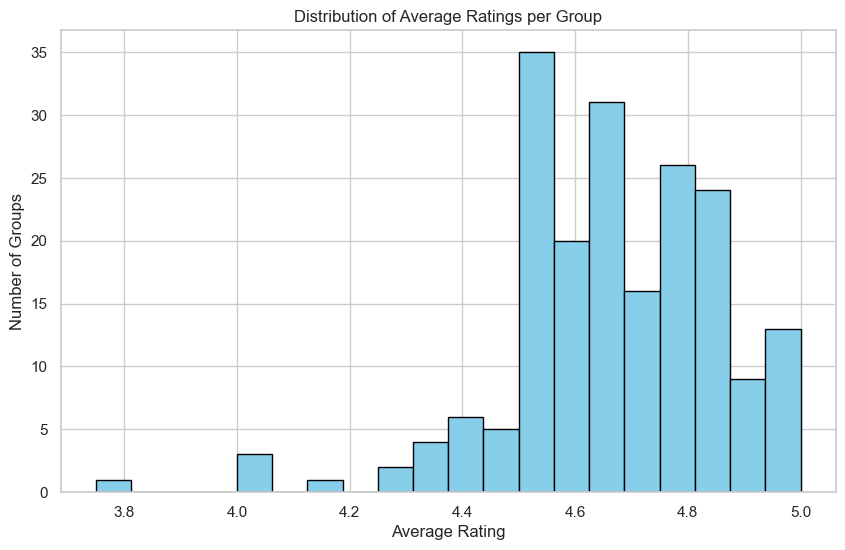

In [139]:
import matplotlib.pyplot as plt

# Create a histogram of average ratings per group
plt.figure(figsize=(10, 6))
plt.hist(group_avg_ratings_df['AverageRating'].dropna(), bins=20, color='skyblue', edgecolor='black')

# Add labels and title in English
plt.xlabel('Average Rating')
plt.ylabel('Number of Groups')
plt.title('Distribution of Average Ratings per Group')

# Show the histogram
plt.show()


In [140]:
import pandas as pd
from tqdm import tqdm
import plotly.express as px

# Assuming `individual_ratings_df` is already defined and contains "GroupID", "UserID", "WineID", and "Rating".

# Schritt 1: Definieren eines Schwellenwerts für Zufriedenheit
satisfaction_threshold = 4.0  # Alle Bewertungen >= 4.0 werden als zufriedenstellend betrachtet

# Schritt 2: Berechnung der Satisfaction Rate für jede Gruppe
satisfaction_rate_per_group = []

# Berechnung der Satisfaction Rate mit `groupby`
for group_id, group_df in individual_ratings_df.groupby('GroupID'):
    # Berechne die Anzahl der zufriedenen Bewertungen (Rating >= threshold)
    satisfied_count = group_df[group_df['Rating'] >= satisfaction_threshold].shape[0]
    
    # Gesamtzahl der Bewertungen für diese Gruppe
    total_count = group_df.shape[0]
    
    # Berechne die Satisfaction Rate, wenn Bewertungen vorhanden sind
    satisfaction_rate = satisfied_count / total_count if total_count > 0 else None
    
    # Speichern der Satisfaction Rate für die aktuelle Gruppe
    satisfaction_rate_per_group.append((group_id, satisfaction_rate))

# Schritt 3: Umwandeln der Liste in einen DataFrame
satisfaction_rate_df = pd.DataFrame(satisfaction_rate_per_group, columns=["GroupID", "SatisfactionRate"])

# Schritt 4: Histogramm erstellen, um die Verteilung der Satisfaction Rate pro Gruppe anzuzeigen
fig = px.histogram(satisfaction_rate_df, x='SatisfactionRate',
                   nbins=10,  # Anzahl der Bins im Histogramm (z.B. 10 für 0-1 in 0.1-Schritten)
                   labels={'SatisfactionRate': 'Satisfaction Rate'},
                   title='Distribution of Satisfaction Rate Across Groups')

# Interaktives Histogramm anzeigen
fig.show()



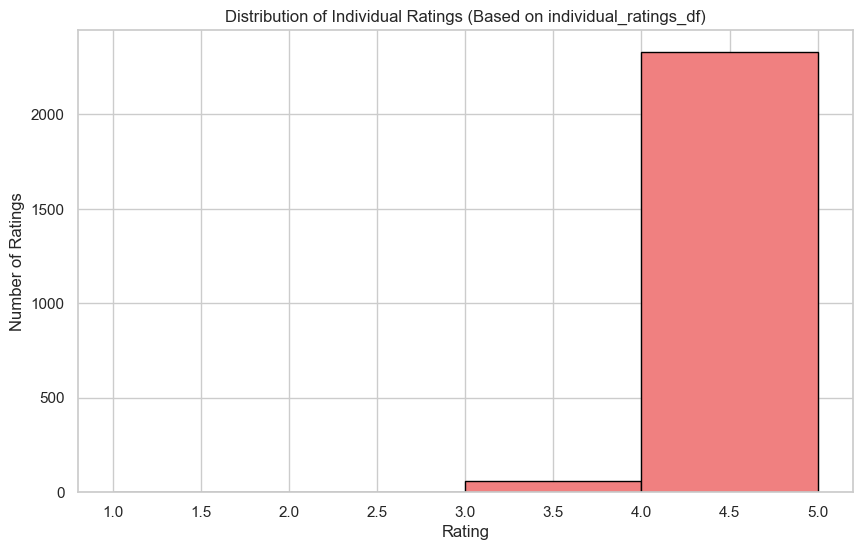

In [141]:
import matplotlib.pyplot as plt

# Stellen Sie sicher, dass `individual_ratings_df` der DataFrame mit den individuellen Bewertungen ist
# und die Spalte "Rating" enthält

# Größe der Grafik festlegen
plt.figure(figsize=(10, 6))

# Histogramm der Spalte `Rating` im DataFrame `individual_ratings_df` erstellen
plt.hist(individual_ratings_df['Rating'], bins=4, color='lightcoral', edgecolor='black')

# Labels und Titel hinzufügen
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Individual Ratings (Based on individual_ratings_df)')

# Histogramm anzeigen
plt.show()


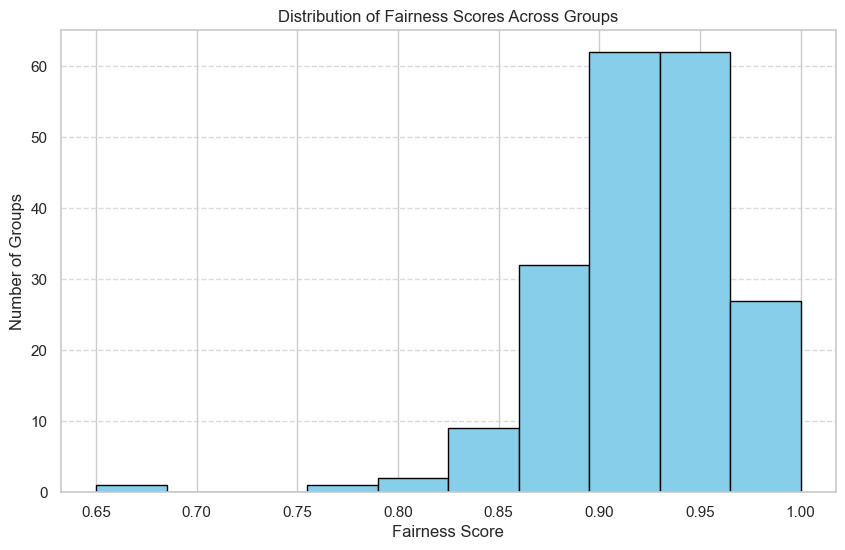

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Beispielannahme: `individual_ratings_df` enthält die Spalten "GroupID", "UserID", "WineID" und "Rating".

# Funktion zur Berechnung der Fairness basierend auf den Bewertungen einer Gruppe
def calculate_fairness(group_ratings_df):
    """
    Berechnet die Fairness basierend auf der Standardabweichung der Gruppenbewertungen.

    Parameter:
    - group_ratings_df: DataFrame mit den Spalten 'UserID', 'WineID' und 'Rating'.

    Rückgabe:
    - Fairness-Score (zwischen 0 und 1), wobei 1 perfekte Fairness bedeutet.
    """
    # Überprüfen, ob keine Bewertungen vorliegen oder alle Bewertungen identisch sind
    if group_ratings_df.empty or len(group_ratings_df['Rating'].unique()) == 1:
        return 1.0  # Perfekte Fairness

    # Berechnung der Standardabweichung der Bewertungen in der Gruppe
    std_dev = group_ratings_df['Rating'].std()

    # Fairness-Score berechnen: 1 - (std deviation) / (max rating - min rating)
    fairness = 1 - (std_dev / (5 - 1))  # max Rating = 5, min Rating = 1

    return round(fairness, 2)  # Fairness-Wert auf 2 Dezimalstellen runden

# Schritt 1: Berechnung der Fairness für jede Gruppe basierend auf `individual_ratings_df`
group_fairness_scores = []  # Speichert die Fairness-Werte für jede Gruppe

# Iteration über alle Gruppen-IDs in `individual_ratings_df` mit `groupby`
for group_id, group_df in individual_ratings_df.groupby('GroupID'):
    # Berechnung der Fairness für die aktuelle Gruppe
    fairness_score = calculate_fairness(group_df)

    # Speichern der Gruppen-ID und des Fairness-Scores
    group_fairness_scores.append({'GroupID': group_id, 'FairnessScore': fairness_score})

# Konvertieren der Ergebnisse in einen DataFrame zur besseren Visualisierung
fairness_df = pd.DataFrame(group_fairness_scores)

# Schritt 2: Visualisierung der Fairness Scores als Histogramm
plt.figure(figsize=(10, 6))  # Größe der Grafik festlegen
plt.hist(fairness_df['FairnessScore'].dropna(), bins=10, color='skyblue', edgecolor='black')  # Histogramm der Fairness-Werte
plt.xlabel('Fairness Score')  # X-Achsen-Beschriftung
plt.ylabel('Number of Groups')  # Y-Achsen-Beschriftung
plt.title('Distribution of Fairness Scores Across Groups')  # Titel des Diagramms
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Gitterlinie für bessere Lesbarkeit
plt.show()


Average Fairness Score: 0.92
Average Satisfaction Rate: 0.97
Average Rating for all groups: 4.66


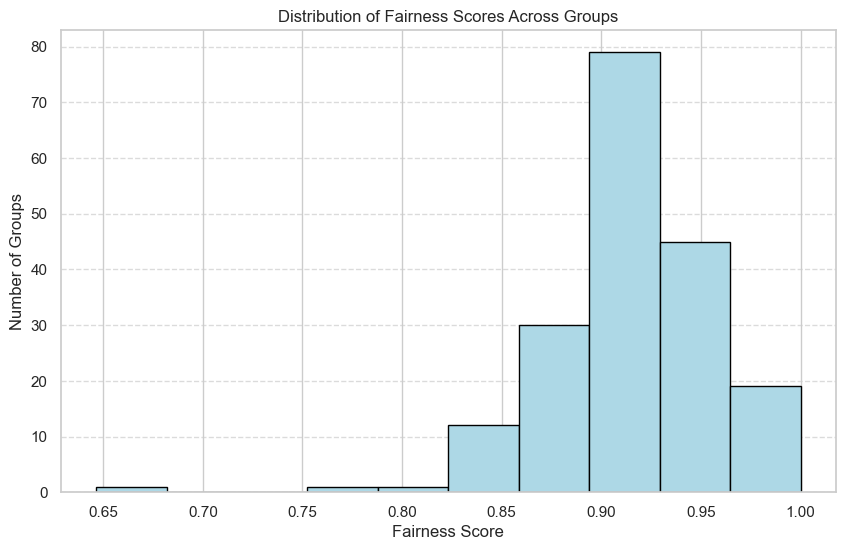

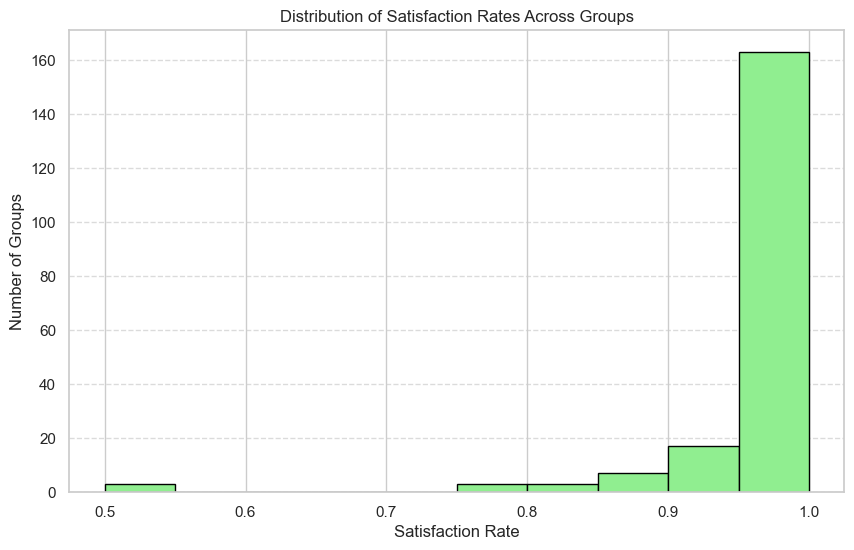

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Annahme: `group_avg_ratings_df` und `individual_ratings_df` sind bereits definiert.

# Schritt 1: Definiere den Zufriedenheitsschwellenwert
satisfaction_threshold = 4.0

# Schritt 2: Berechnung des Fairness Scores pro Gruppe
# Berechnen der Standardabweichung der Bewertungen für jede Gruppe
group_fairness_df = (
    individual_ratings_df.groupby('GroupID')['Rating']
    .std()  # Berechne die Standardabweichung pro Gruppe
    .reset_index()  # Zurücksetzen des Index
    .rename(columns={'Rating': 'StdDev'})  # Spalte umbenennen
)

# Berechnung des Fairness Scores: 1 - (Standardabweichung / (max rating - min rating))
group_fairness_df['FairnessScore'] = 1 - (group_fairness_df['StdDev'] / (5 - 1))

# Schritt 3: Berechnung der Satisfaction Rate pro Gruppe
# Berechnen des Anteils der zufriedenstellenden Bewertungen (z.B. >= 4.0) für jede Gruppe
group_satisfaction_df = (
    individual_ratings_df[individual_ratings_df['Rating'] >= satisfaction_threshold]  # Filter auf Zufriedenheitsbewertungen
    .groupby('GroupID').size()  # Anzahl zufriedener Bewertungen pro Gruppe
    .reset_index(name='SatisfiedCount')
)

# Berechnung der Gesamtanzahl der Bewertungen pro Gruppe
total_ratings_df = individual_ratings_df.groupby('GroupID').size().reset_index(name='TotalRatings')

# Merge der beiden DataFrames: Zufriedene Bewertungen + Gesamtanzahl
group_satisfaction_df = pd.merge(group_satisfaction_df, total_ratings_df, on='GroupID')

# Berechnung der Satisfaction Rate
group_satisfaction_df['SatisfactionRate'] = group_satisfaction_df['SatisfiedCount'] / group_satisfaction_df['TotalRatings']

# Schritt 4: Berechnung der durchschnittlichen Werte
overall_avg_rating = round(group_avg_ratings_df['AverageRating'].mean(), 2)
overall_fairness = round(group_fairness_df['FairnessScore'].mean(), 2)
overall_satisfaction = round(group_satisfaction_df['SatisfactionRate'].mean(), 2)

# Schritt 5: Ausgabe der durchschnittlichen Werte
print(f"Average Fairness Score: {overall_fairness}")
print(f"Average Satisfaction Rate: {overall_satisfaction}")
print(f"Average Rating for all groups: {overall_avg_rating}")

# Schritt 6: Visualisierung der Fairness Scores als Histogramm
plt.figure(figsize=(10, 6))
plt.hist(group_fairness_df['FairnessScore'].dropna(), bins=10, color='lightblue', edgecolor='black')
plt.xlabel('Fairness Score')
plt.ylabel('Number of Groups')
plt.title('Distribution of Fairness Scores Across Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Schritt 7: Visualisierung der Satisfaction Rates als Histogramm
plt.figure(figsize=(10, 6))
plt.hist(group_satisfaction_df['SatisfactionRate'].dropna(), bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Satisfaction Rate')
plt.ylabel('Number of Groups')
plt.title('Distribution of Satisfaction Rates Across Groups')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
